In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from autocorrect import Speller
import unidecode
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score

In [2]:
humorousQ = pd.read_csv("Humorous.csv")
non_humorousQ = pd.read_csv("Non-humorous-unbiased.csv")


In [3]:
questions = pd.concat([humorousQ, non_humorousQ], ignore_index=True)
questions.rename(columns={'label': 'humor'}, inplace=True)
questions.drop(['product_description', 'image_url'], axis=1, inplace=True)
questions

,question,humor
0,Will the volca sample get me a girlfriend?,1
1,Can u communicate with spirits even on Saturday?,1
2,I won't get hunted right?,1
3,I have a few questions.. Can you get possessed...,1
4,Has anyone asked where the treasure is? What w...,1
...,...,...
19137,Serve na f800r 2013?,0
19138,Can it run mine sweeper abve 10 fps?,0
19139,What is the difference between the pro weight ...,0
19140,Can you provide me a phone number to the compa...,0


In [4]:
def case_convert():
    questions.question = [i.lower() for i in questions.question.values]

def remove_specials():
    questions.text =  [re.sub(r"[^a-zA-Z]"," ",text) for text in questions.question.values]

def remove_shorthands():
    CONTRACTION_MAP = {
    "u": "you",
    "abve": "above",
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
    texts = []
    for text in questions.question.values:
        string = ""
        for word in text.split(" "):
            if word.strip() in list(CONTRACTION_MAP.keys()):
                string = string + " " + CONTRACTION_MAP[word]
            else:
                string = string + " " + word
        texts.append(string.strip())
    questions.question = texts

def remove_stopwords():
    texts = []
    stopwords_list = stopwords.words('english')
    for item in questions.question.values:
        string = ""
        for word in item.split(" "):
            if word.strip() in stopwords_list:
                continue
            else:
                string = string + " " + word
        texts.append(string)
                
def remove_links():
    texts = []
    for text in questions.question.values:
        remove_https = re.sub(r'http\S+', '', text)
        remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
        texts.append(remove_com)
    questions.question = texts

def remove_accents():
    questions.question = [unidecode.unidecode(text) for text in questions.question.values]

def normalize_spaces():
    questions.question = [re.sub(r"\s+"," ",text) for text in questions.question.values]

case_convert()
remove_links()
remove_shorthands()
remove_accents()
remove_specials()
remove_stopwords()
normalize_spaces()
print(questions)

C:\Users\grbha\AppData\Local\Temp\ipykernel_20136\4241353287.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  questions.text =  [re.sub(r"[^a-zA-Z]"," ",text) for text in questions.question.values]


                                                question  humor
0             will the volca sample get me a girlfriend?      1
1      can you communicate with spirits even on satur...      1
2                           i will not get hunted right?      1
3      i have a few questions.. can you get possessed...      1
4      has anyone asked where the treasure is? what w...      1
...                                                  ...    ...
19137                               serve na f800r 2013?      0
19138              can it run mine sweeper above 10 fps?      0
19139  what is the difference between the pro weight ...      0
19140  can you provide me a phone number to the compa...      0
19141                 is the blenders sponge latex free?      0

[19142 rows x 2 columns]


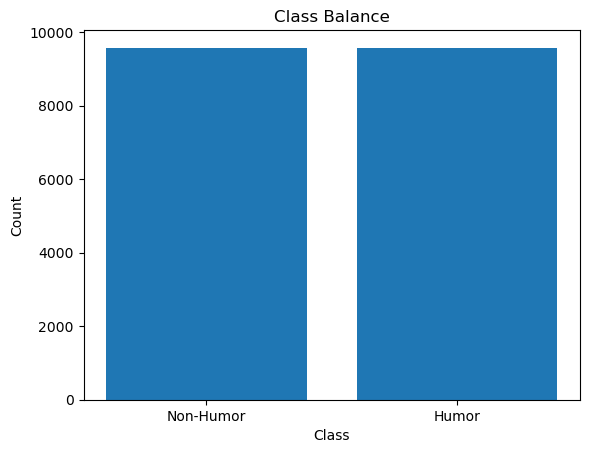

In [5]:
un, count = np.unique(questions.humor, return_counts=True)
plt.bar(["Humor" if i == 1 else "Non-Humor" for i in un], count)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Balance")
plt.show()

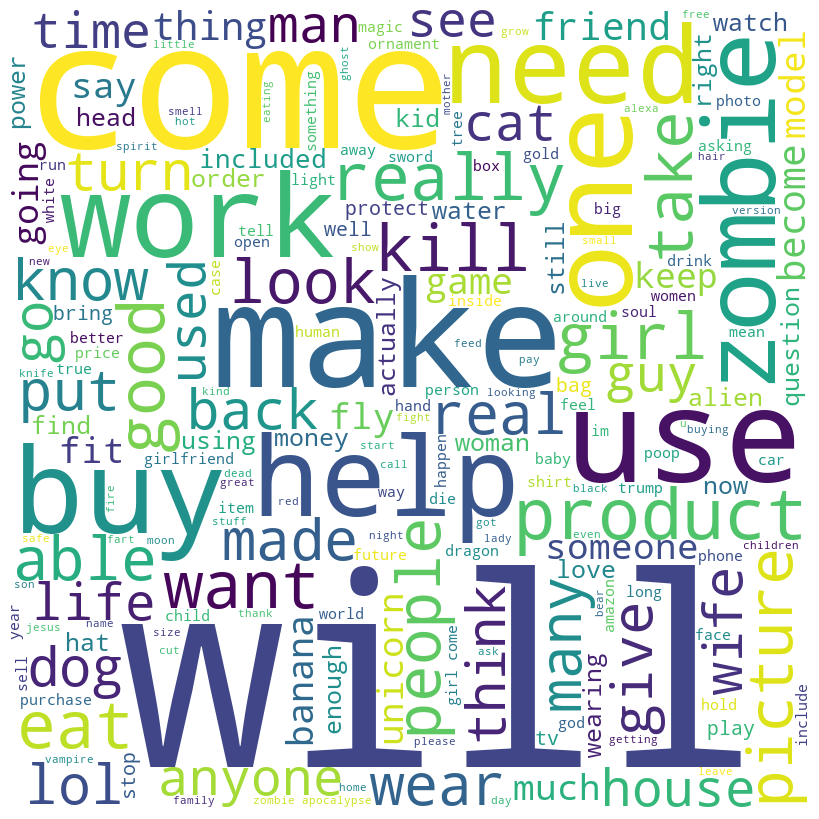

In [6]:
string = ""
for i in questions[questions.humor == 1].question.values:
    string = string + " " + i.strip()
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(string)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()
del string

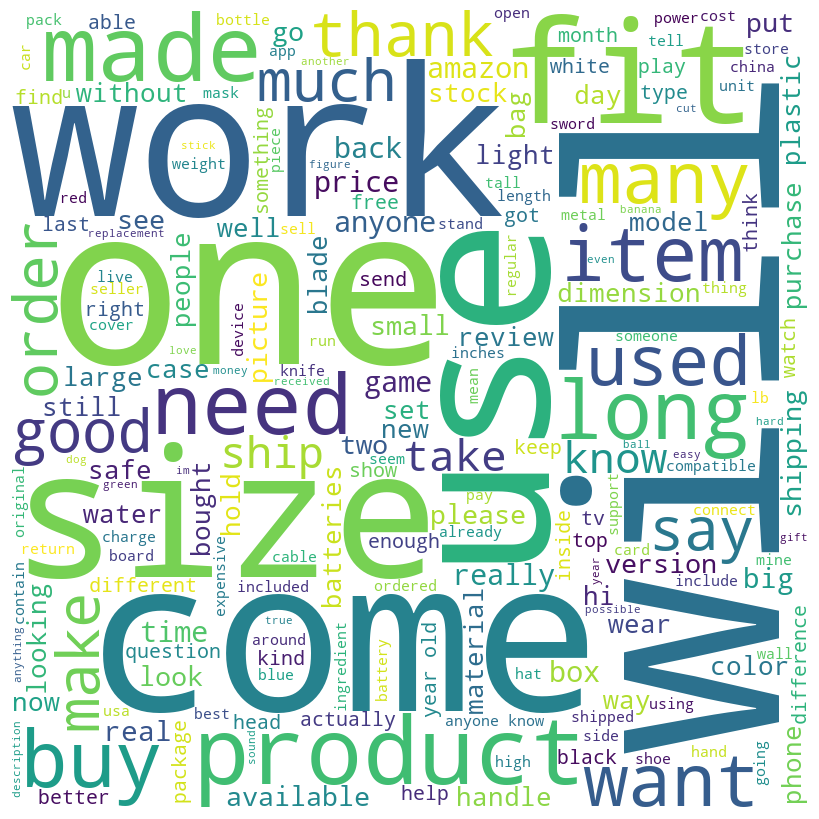

In [7]:
string = ""
for i in questions[questions.humor == 0].question.values:
    string = string + " " + i.strip()
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(string)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()
del string

In [8]:
sentiment = []
for text in questions.question.values:
    polarity = TextBlob(text).sentiment.polarity
    if polarity < 0:
        sentiment.append("Negative")
    elif polarity == 0:
        sentiment.append("Neutral")
    else:
        sentiment.append("Positive")
questions["sentiment"] = sentiment
del sentiment

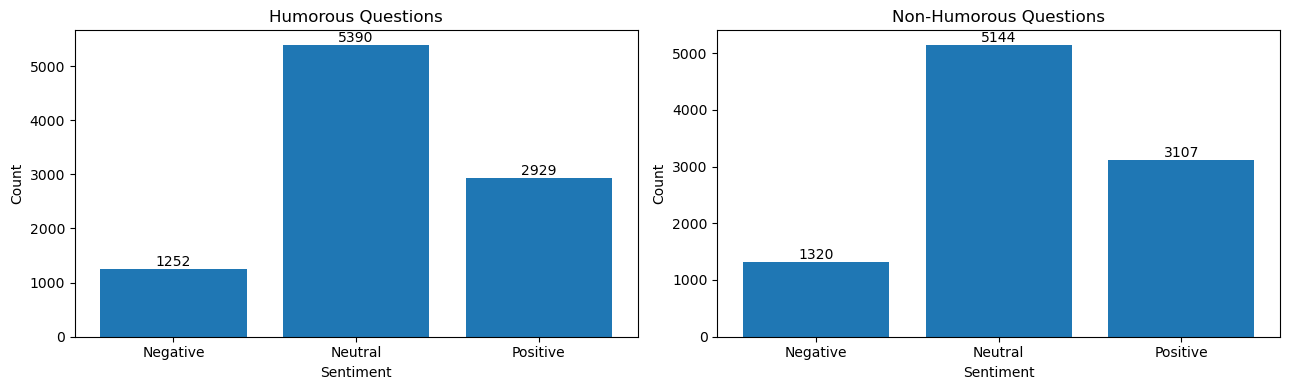

In [9]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
un, count = np.unique(questions[questions.humor == 1].sentiment,return_counts=True)
bars = plt.bar(un, count)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Humorous Questions")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')
    
    
plt.subplot(1,2,2)
un, count = np.unique(questions[questions.humor == 0].sentiment,return_counts=True)
bars = plt.bar(un, count)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Non-Humorous Questions")
plt.tight_layout()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

In [10]:
vec = TfidfVectorizer(max_features=3000)

X_train, X_test, Y_train, Y_test = train_test_split(vec.fit_transform(questions.question.values).toarray(), 
                                                    questions.humor.values.reshape(-1,1), 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)

In [11]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.35657643, ..., 0.        , 0.        ,
        0.        ]])

In [12]:
Y_train

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]], dtype=int64)

In [13]:
model = RandomForestClassifier(n_estimators = 100, random_state=42)
model.fit(X_train, Y_train.ravel())

RandomForestClassifier(random_state=42)

In [14]:
print("Train Accuracy  : {:.2f} %".format(accuracy_score(model.predict(X_train), Y_train)*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(model.predict(X_test), Y_test)*100))
print("Precision       : {:.2f} %".format(precision_score(model.predict(X_test), Y_test)*100))
print("Recall          : {:.2f} %".format(recall_score(model.predict(X_test), Y_test)*100))

Train Accuracy  : 99.50 %
Test Accuracy   : 76.91 %
Precision       : 72.93 %
Recall          : 79.68 %


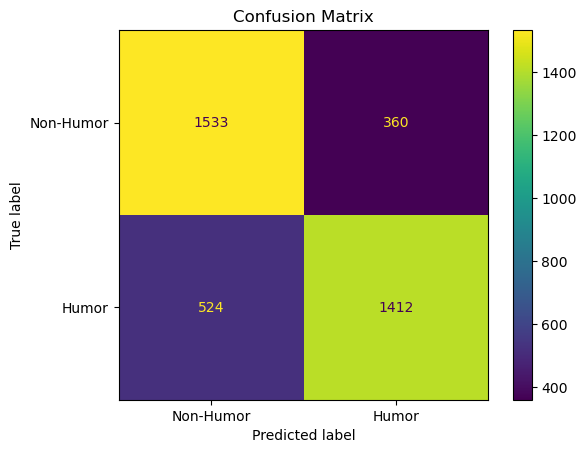

In [15]:
cm = confusion_matrix(Y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-Humor","Humor"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

AUC Score: 0.8533487609854488


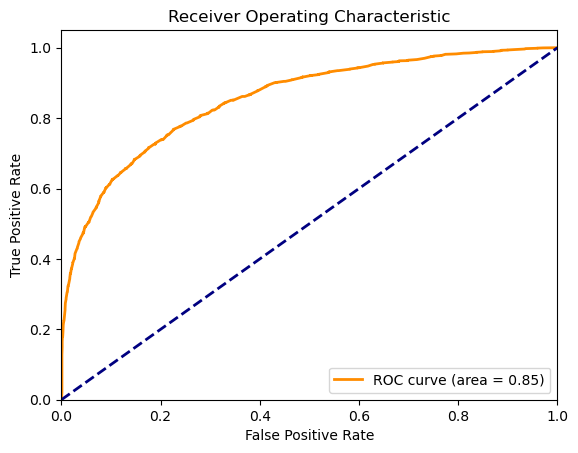

In [16]:
Y_pred_proba = model.predict_proba(X_test)[:, 1]

# Step 3: Calculate the AUC score
auc_score = roc_auc_score(Y_test, Y_pred_proba)
print(f"AUC Score: {auc_score}")

# Generate ROC curve values: false positive rates, true positive rates, thresholds
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [17]:
#Optimizing hyperparameters
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the base model to tune
rf = RandomForestClassifier(random_state=42)
scorer = make_scorer(accuracy_score)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring=scorer, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, Y_train.ravel())  # Ensure Y_train is flattened using ravel()

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Retrieve the best estimator
model = grid_search.best_estimator_

# Now you can use best_rf to make predictions, and evaluate its performance

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.7666686711648458


In [18]:
print("Train Accuracy  : {:.2f} %".format(accuracy_score(model.predict(X_train), Y_train)*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(model.predict(X_test), Y_test)*100))
print("Precision       : {:.2f} %".format(precision_score(model.predict(X_test), Y_test)*100))
print("Recall          : {:.2f} %".format(recall_score(model.predict(X_test), Y_test)*100))

Train Accuracy  : 99.46 %
Test Accuracy   : 77.30 %
Precision       : 74.33 %
Recall          : 79.46 %


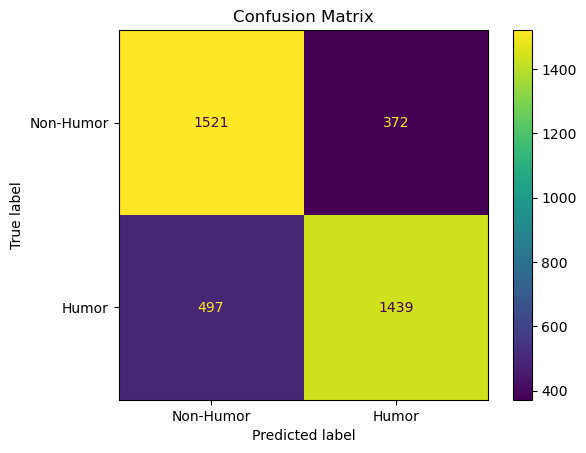

In [19]:
cm = confusion_matrix(Y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-Humor","Humor"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

AUC Score: 0.8559002992757135


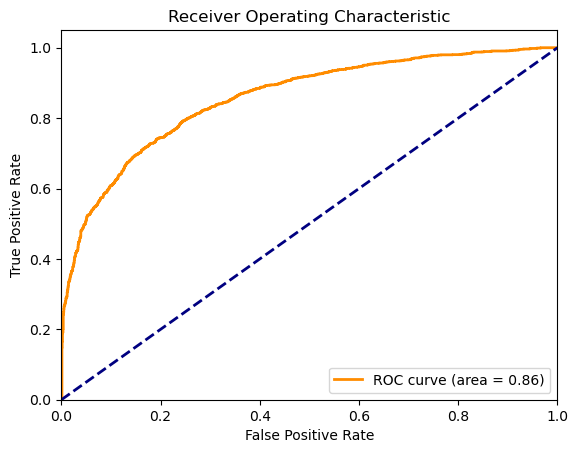

In [20]:
Y_pred_proba = model.predict_proba(X_test)[:, 1]

# Step 3: Calculate the AUC score
auc_score = roc_auc_score(Y_test, Y_pred_proba)
print(f"AUC Score: {auc_score}")

# Generate ROC curve values: false positive rates, true positive rates, thresholds
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()